# Conversion Rate Optimization using Classification Model

The data revolution enable us to collect all sorts of data about customers who purchase on a website as well as potential customers who had not yet purchase. These data can reveal insights on what's working well (and potentially scale it even further) and what's not working well (and fix it).

The goal of this project is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.


## Goal
* Predict conversion rate
* Come up with recommendations for the product team and the marketing team to improve conversion rate


## Description of data
Website users information: 
* Whether they converted or not ; 
* User characteristics: Country; The marketing channel; Age; Repeat users or not; The number of pages visited during that session (as a proxy for site activity/time spent on site).

### Columns:
* country : user country based on the IP address
* age : user age. Self-reported at sign-in step
* new_user : whether the user created the account during this session or had already an account and simply came back to the site
* source : marketing channel source
* Ads: came to the site by clicking on an advertisement
* Seo: came to the site by clicking on search results
* Direct: came to the site by directly typing the URL on the browser
* total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.



## 1. Exploratory Data Analysis and Feature Generation 
### 1.1 Read data from csv file

In [3]:
# import necessary pacakges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn import base
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [4]:
# read data as a pandas dataframe
data = pd.read_csv("conversion_data.csv")
print(data.shape)    # check size of the data, there are 31.6K user records
data.head()          # look at the first 5 rows of data

(316200, 6)


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


### 1.2 Data cleaning
Look at the data to check any usual values. First we get some summary on numeric data. 

In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Some findings:
* 68.5% of the users are new users;
* Overall conversion rate is 0.0323;
* The maximum age looks odd and need futher investigation.

In [6]:
data.sort_values(by='age', ascending = False).head()

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0


It's not likely that a customer's age is >100 and we have a large sample, so I just drop those 2 records. 

In [41]:
data = data.loc[data['age']<100].reset_index().drop('index', axis=1)

### 1.3 Exploratory analysis
### 1.3.1 Histogram of numeric variables
First, plot the histogram of each continous variable age and total_pages_visited by 'converted'. 


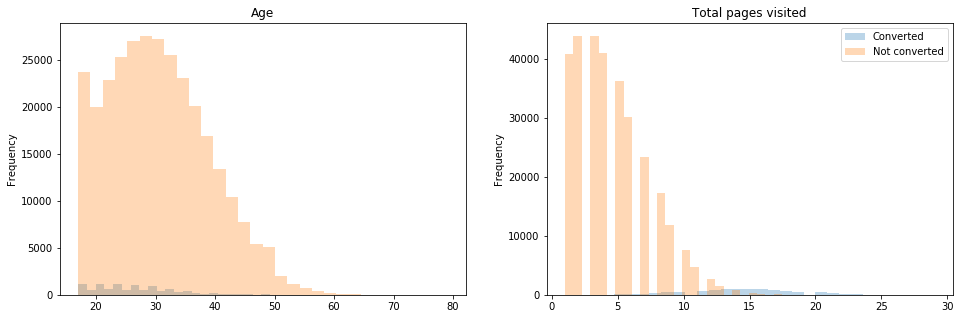

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

data.loc[data['converted']==1 ,'age'].plot.hist( bins= 30, ax=axes[0], alpha=.3, title= 'Age', label='Converted')
data.loc[data['converted']==0 ,'age'].plot.hist( bins= 30, ax=axes[0], alpha=.3, label='Not converted')

data.loc[data['converted']==1 ,'total_pages_visited'].plot.hist( bins= 30, ax=axes[1], alpha=.3, 
                                                                title= 'Total pages visited', label='Converted')
data.loc[data['converted']==0 ,'total_pages_visited'].plot.hist( bins= 30, ax=axes[1], alpha=.3,  label='Not converted')

plt.legend()

Findings:
* There are more younger users (age 20-40) than older users (age >40); Hard to observe difference in age between  converted users and users who did not convert.
* Conversion is associated with more total pages visited. 

Explore relationship between total_pages_visited and age:

                     total_pages_visited       age
total_pages_visited             1.000000 -0.000465
age                            -0.000465  1.000000
                     total_pages_visited       age
total_pages_visited             1.000000  0.001367
age                             0.001367  1.000000


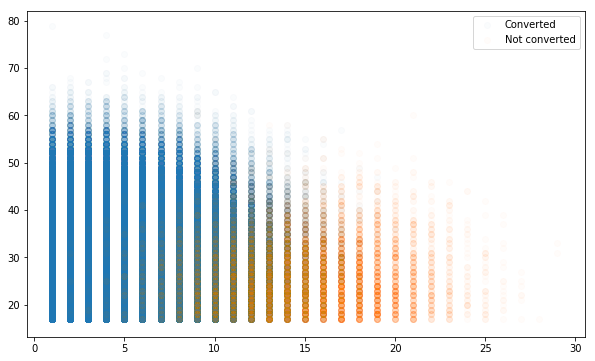

In [9]:
# compute correlation between age and total_pages_visted:
print(data.loc[data['converted']==1][['total_pages_visited','age']].corr())
print(data.loc[data['converted']==0][['total_pages_visited','age']].corr())

# visualized the relationship by converted or not

plt.figure(figsize= (10,6))
plt.scatter(data.loc[data['converted']==0, 'total_pages_visited'], data.loc[data['converted']==0, 'age'], 
            label = 'Converted', alpha=0.02)
plt.scatter(data.loc[data['converted']==1, 'total_pages_visited'], data.loc[data['converted']==1, 'age'], 
            label =  'Not converted', alpha=0.02)
plt.legend()

### 1.3.2 Frequency table of categorical features by Converted

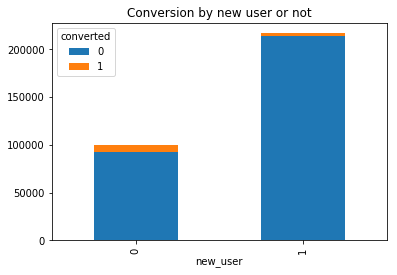

In [10]:
data.groupby([ 'new_user', 'converted']).size().unstack().plot.bar(stacked= True, title ="Conversion by new user or not")

In [11]:
data[['converted','new_user']].groupby(['new_user']).mean()

,converted
new_user,
0,0.071983
1,0.014021


Finding: There are more new users than users who already have an account, but return user have higher conversion rate.

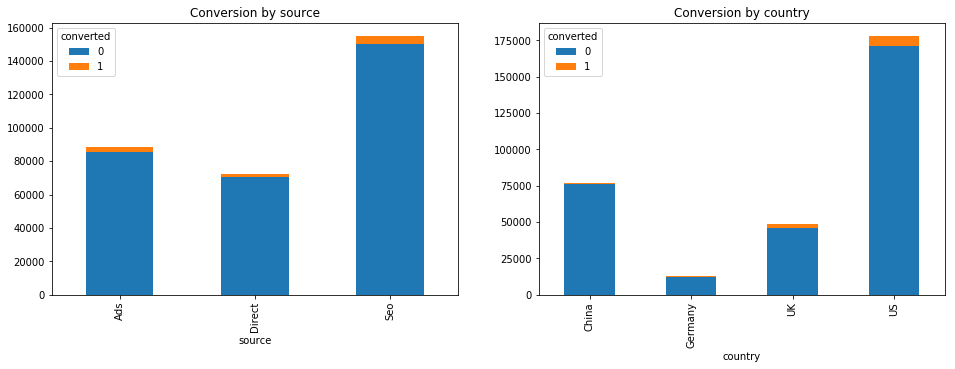

In [12]:
tmp1 = data.groupby(['country', 'converted']).size().unstack()
tmp2 = data.groupby(['source', 'converted']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
tmp2.plot.bar(stacked= True, ax=axes[0], title = 'Conversion by source')
tmp1.plot.bar(stacked= True, ax=axes[1], title = 'Conversion by country')

In [13]:
data[['converted','source']].groupby(['source']).mean()

,converted
source,
Ads,0.034472
Direct,0.028169
Seo,0.032888


In [14]:
data[['converted','country']].groupby(['country']).mean()

,converted
country,
China,0.001332
Germany,0.062428
UK,0.052612
US,0.037801


### 1.4 Build a python class for feature generation - One Hot Encoding
use OneHotEncoder, LabelEncoder from sklearn to convert categorical variables (UniqueCarrier, Month and Hour) into binary variables to use for model fitting.

* Build a custom transformer that will transform data to features we want:

In [15]:
# (base.BaseEstimator, base.TransformerMixin)-> this class will have .fit(),.fit_transform( mothods

class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, categorical_variables, numeric_variables): 
        # parameters taken by the transformer: a list of categorical_variables, a list of numeric_variables
        self.categorical_variables = categorical_variables  # We will need these in transform()
        self.numeric_variables     = numeric_variables
    
    def fit(self, X, y=None):
        # Create empty list to store encode fit
        self.label_encode = [] 
        self.OneHot_encode = []
        
        # fit LabelEncoder and OneHotEncoder to data
        for i, column in enumerate(self.categorical_variables):
            LE = LabelEncoder()                 # encode categorical variables as numeric
            OHE = OneHotEncoder( sparse=False)  # do one hot encoding
            OHE.fit(LE.fit_transform( X[column]).reshape(-1,1))
            self.label_encode.append( LE )    
            self.OneHot_encode.append( OHE )  
        return self
    
    def transform(self, X):
        X = X.reset_index() 
        df_cat = []  # empty list to store transformation result for each categorical variable
        
        # use LabelEncoder and OneHotEncoder to transform data
        for i, column in enumerate(self.categorical_variables):
            df_feature = self.OneHot_encode[i].transform(self.label_encode[i].transform( X[column]).reshape(-1,1))
            df_feature = pd.DataFrame(df_feature)
            df_feature.columns = [column  +'_'+str(x) for x in list(self.label_encode[i].classes_)]
            df_cat.append(df_feature)
            
        # Merge these dummary variables with numeric features: 
        df_numeric = X[self.numeric_variables]
        X = pd.concat([df_numeric]+ df_cat, axis=1) 
        
        return X 

* Transform data, 
* list feature names
* look at the transformed feature matrix

In [16]:
CT = ColumnSelectTransformer(categorical_variables=['country','source' ], 
                                numeric_variables=['total_pages_visited','age','new_user'])
df_feature = CT.fit_transform(data)
columns = list(df_feature.columns)
print(columns)
df_feature.head()

['total_pages_visited', 'age', 'new_user', 'country_China', 'country_Germany', 'country_UK', 'country_US', 'source_Ads', 'source_Direct', 'source_Seo']


,total_pages_visited,age,new_user,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,1,25,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,5,23,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,4,28,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,5,39,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,30,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## 2. Build models to predict whether a user will convert.
Build prediction models using features generated above.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, f1_score

### 2.1 Split data into training set and test set
Split data into traing set(75%) and test set(25%): 

In [18]:
X =  data.drop('converted', axis=1)
y = data['converted']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size= 0.25, random_state=42)

### 2.2 Fit different classifiers to training data and plot ROC curve using test data

Logistic Regression: Test F1 score 0.769128704113 , Test Accuracy 0.98679316888
Confusion matrix of test data:
[[76267   286]
 [  758  1739]]
Decision Tree: Test F1 score 0.739216987392 , Test Accuracy 0.985085388994
Confusion matrix of test data:
[[76200   353]
 [  826  1671]]
Regularized Logistic Regression: Test F1 score 0.769502762431 , Test Accuracy 0.986805819102
Confusion matrix of test data:
[[76266   287]
 [  756  1741]]
Random Forest: Test F1 score 0.757239277161 , Test Accuracy 0.985895003163
Confusion matrix of test data:
[[76196   357]
 [  758  1739]]
Naive Bayes: Test F1 score 0.597099800967 , Test Accuracy 0.964149272612
Confusion matrix of test data:
[[74116  2437]
 [  397  2100]]


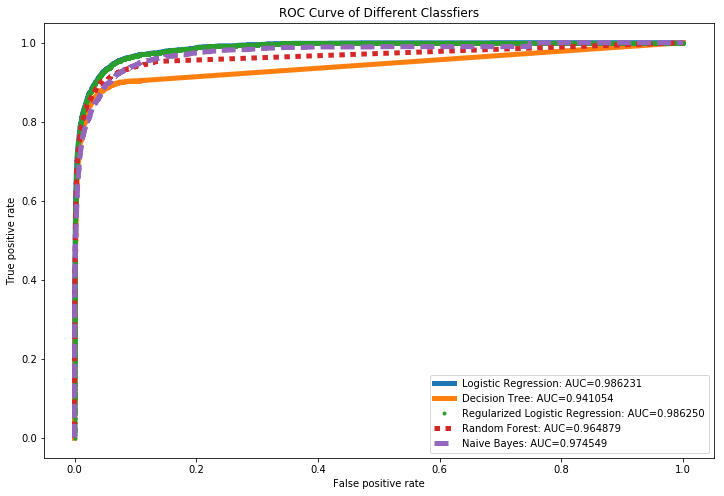

In [19]:
#max_depth= 10, n_estimators = 10, max_features= 10
# name -> (line format, classifier)
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

CLASS_MAP ={
    'Logistic Regression': ('-', LogisticRegression() ),
    'Regularized Logistic Regression': ('.', GridSearchCV(LogisticRegression(penalty= 'l2'), {'C':np.logspace(-2, 2.0, num=10)}) ),
    'Naive Bayes' :('--', GaussianNB() ),
    'Decision Tree' :('.-',DecisionTreeClassifier(min_samples_split=10) ) ,
    'Random Forest': (':', RandomForestClassifier(min_samples_split=20)),
}

plt.figure(figsize= (12,8))
for name, (line_fmt, clf) in CLASS_MAP.items():
    # train model
    model = Pipeline([
        ('ColSelect', CT ),# ColumnSelectTransformer
        ('clf', clf)       # classifier
    ])
    
    model.fit( X_train, y_train)
    # predict probability on test data
    preds = model.predict_proba(X_test)
    pred = pd.Series(preds[:, 1])
    
    # Calcualte FPR, TPR for plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    auc_score = auc(fpr, tpr)
    label = '%s: AUC=%f' %(name, auc_score)
    plt.plot(fpr, tpr, line_fmt, linewidth=5, label= label)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    print(name + ': Test F1 score', f1_score(y_test, test_pred), #sum(train_pred== y_train)/len(y_train),
          ', Test Accuracy', accuracy_score(y_test, test_pred))

    #print('Confusion matrix of train data:')
    #print(confusion_matrix(y_train, train_pred))
    print('Confusion matrix of test data:')
    print(confusion_matrix(y_test, test_pred))
plt.legend(loc= 'lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve of Different Classfiers')

In [20]:
#accuracy of predicting all flights to be not canceled:
sum(y_test==0)/len(y_test)

0.96841239721695127

### Findings: 
* All models have similar AUC. 
* Beause conversion rate is low, even using the simplest model predicting all user not to convert, the accuracy is high (0.9684).
* So accuracy is not a good metric in this case, F1 score is better.
* I choose logistic classifier to be the final prediction model, which is a simple model with high F1 score and high accuracy.

Logistic Regression is an excellent algorithm for classification. Even though some of the sexier, black box classification algorithms like SVM and RandomForest can perform better in some cases, it's hard to deny the value in knowing exactly what your model is doing. Often times you can get by using RandomForest to select the features of your model and then rebuild the model with Logistic Regression using the best features.

### 2.3 Fit the final model using all data:

### Model fitting using scikit-learn LogisticRegression

* The pipeline approach is very convenient to comparedifferent models.
* However, becasue we include all categories when creating dummy variables in the transformer class, 
it will have multi-colinearity problem for logistic regression. 
* A better way is to set a reference category for each categorical variable and remove that before fitting model.
* Here I set US as reference for country and direct as a reference for source.


In [21]:
df = CT.fit_transform(data).drop(['country_US', 'source_Direct'], axis= 1)
clf = LogisticRegression()
clf.fit(df, data['converted'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
print(clf.intercept_)
pd.DataFrame( clf.coef_[0] , list(df.columns))


[-7.20086815]


,0
total_pages_visited,0.754838
age,-0.075214
new_user,-1.735214
country_China,-3.179391
country_Germany,0.564013
country_UK,0.366504
source_Ads,0.173303
source_Seo,0.150062


### Model fitting using statsmodels
* Point estimates given by sklearn is not enough for model interpretation, so I use the package statsmodels which produces p-values and confidence intervals for fitting a logistic model.

In [45]:
import statsmodels.api as sm
import pylab as pl
logit = sm.Logit(data['converted'], df)
# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.052938
         Iterations 11


In [48]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               316198
Model:                          Logit   Df Residuals:                   316190
Method:                           MLE   Df Model:                            7
Date:                Wed, 02 Aug 2017   Pseudo R-squ.:                  0.6285
Time:                        23:07:11   Log-Likelihood:                -16739.
converged:                       True   LL-Null:                       -45053.
                                        LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
total_pages_visited     0.6021      0.005    128.610      0.000       0.593       0.611
age                    -0.2388      0.002   -127.803      0.000      -0.242      -0.235
new_user               -2.1997      0.031    -70.077      0.000      -2.261      -2.138
country_China          -3.7419      0.112    -33.516      0.000      -3.961      -3.523
country_Germany         0.1850      0.063      2.937      0.003       0.062       0.308
country_UK             -0.0254      0.037     -0.690      0.490      -0.097       0.047
source_Ads             -0.8836      0.039    -22.664      0.000      -0.960      -0.807
source_Seo             -0.9245      0.034    -27.110      0.000      -0.991      -0.858
=======================================================================================

Possibly complete quasi-separation: A fraction 0.31 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

We get a great overview of the coefficients of the model, how well those coefficients fit, the overall fit quality, and several other statistical measures.

#### Odds ratio

Take the exponential of each of the coefficients to generate the odds ratios. This tells you how a 1 unit increase or decrease in a variable affects the odds of being admitted. 
* For example, we can expect the odds of conversion decrease by about 89% if the user is a new user.

We can also do the same calculations using the coefficients estimated using the confidence interval to get a better picture for how uncertainty in variables can impact the conversion rate.

In [52]:
# odds ratios and 95% CI
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf))

                         2.5%     97.5%        OR
total_pages_visited  1.809325  1.842836  1.826004
age                  0.784706  0.790474  0.787585
new_user             0.104227  0.117874  0.110841
country_China        0.019050  0.029509  0.023709
country_Germany      1.063483  1.361264  1.203196
country_UK           0.907106  1.047850  0.974942
source_Ads           0.382897  0.446121  0.413302
source_Seo           0.371096  0.424168  0.396746


### Interpretation:
* Country effect: The probability of conversion is higher for users in China is lower than that of users in the US, which is again lower than conversion rate in German users. 
* The odds of conversion for new users are 89% lower than that of a user who already have an account.
* For every year increase in age, the odds of conversion descrease by 11%.
* The odds of conversion for Ads or SEO are both 60% lower compared with that of direct source.

## 3. Recommendations for the product team and the marketing team
Recommendations for the product team and the marketing team to improve conversion rate:
We want to improve our product and increase marketing effects to target users with lower conversion rate. 

The groups of users with lower conversion rate right now are:
* users older in age, 
* users with fewer total page visited
* new users
* Chinese users
* users from the source of Ads and search engine optimization(SEO).